In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from darts import TimeSeries
from darts.models import TCNModel, RNNModel
from darts.dataprocessing.transformers import Scaler
from darts.utils.likelihood_models import GaussianLikelihood
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import mape, r2_score, rmse
from darts.utils.missing_values import fill_missing_values
from darts.datasets import AirPassengersDataset, SunspotsDataset, EnergyDataset
from darts.utils.statistics import check_seasonality, plot_acf, stationarity_tests

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 10)

Importing plotly failed. Interactive plots will not work.


In [2]:
# Read data:

missing_values = ["n/a", "na", "NaN", "--", "null"]
df = pd.read_csv('data/CombinedMacroSectorv4.csv', sep=",", na_values = missing_values, index_col=None)
print(df.shape)

(4275, 22)


In [3]:
df.head()

,Date,Oil,Inflation,CPI,Dollar Index,GDP,Unemployment,Recession,Energy,Gold,...,Customer Discretionary,Consumer Staples,Health,Financials,Technology,Telecommunications,Utilities,Real Estate,Cycle,Spy
0,9/29/04,49.53,2.34,189.8,88.099998,3.8,5.4,0,34.720001,NaN,...,31.070000,21.610001,29.350000,23.176279,19.049999,22.680000,25.000000,49.849998,ExpandBeforePeak,129.00000
1,9/30/04,49.56,2.37,189.8,87.360001,3.8,5.4,0,34.930000,NaN,...,31.200001,21.660000,28.790001,23.119415,19.120001,22.620001,25.049999,50.250000,ExpandBeforePeak,130.09375
2,10/1/04,50.16,2.38,190.8,87.629997,4.1,5.5,0,35.430000,NaN,...,31.590000,21.879999,29.059999,23.509342,19.600000,22.990000,25.250000,51.180000,ExpandBeforePeak,129.43750
3,10/4/04,49.85,2.33,190.8,88.379997,4.1,5.5,0,35.389999,NaN,...,31.889999,21.830000,29.190001,23.541836,19.760000,23.309999,25.350000,51.400002,ExpandBeforePeak,127.81250
4,10/5/04,51.08,2.34,190.8,88.169998,4.1,5.5,0,35.770000,NaN,...,31.850000,21.830000,29.100000,23.411860,19.900000,23.400000,25.459999,51.389999,ExpandBeforePeak,130.12500


In [4]:
df['time'] = pd.to_datetime(df['Date'],utc=True)
df['time']= df.time.dt.tz_localize(None)
#df['Time'] = normalize(df)
#df['Class'] = df['Recession']
#std_normalize(["Oil", "Inflation", "CPI", "Dollar Index", "GDP", "Unemployment", "Energy", "Gold",
#"Materials", "Industrials", "Customer Discretionary", "Consumer Staples", "Health",
#"Financials", "Technology", "Telecommunications", "Utilities", "Real Estate", "Spy"], df)
df.drop(['Date'], axis=1, inplace=True)
#df.drop(['Cycle'], axis=1, inplace=True)
#df.drop(['Gold'], axis=1, inplace=True)

#ts = scaler.fit_transform(
#    ts
#)  # scale the whole time series not caring about train/val split...

In [5]:
daily_cov = pd.read_csv('data/news_sentiment_data.csv', sep=",", na_values = missing_values, index_col=None)
print(daily_cov.shape)

(5985, 2)


In [6]:
daily_cov.head()

,date,sentiment
0,9/29/04,0.167411
1,9/30/04,0.173788
2,10/1/04,0.167044
3,10/2/04,0.161869
4,10/3/04,0.165404


In [7]:
daily_cov['time'] = pd.to_datetime(daily_cov['date'],utc=True)
daily_cov['time']= daily_cov.time.dt.tz_localize(None)
daily_cov.drop(['date'], axis=1, inplace=True)
#daily_cov = daily_cov.time.isin(df.time)
daily_cov = daily_cov[daily_cov.time.isin(df.time)]
print(daily_cov.shape)

(4275, 2)


In [8]:
series_cov = TimeSeries.from_dataframe(daily_cov, 'time', ["sentiment"])

In [9]:
scaler_cov = Scaler(MinMaxScaler(feature_range=(-1, 1)))
series_cov_transformed = scaler_cov.fit_transform(
    series_cov
)

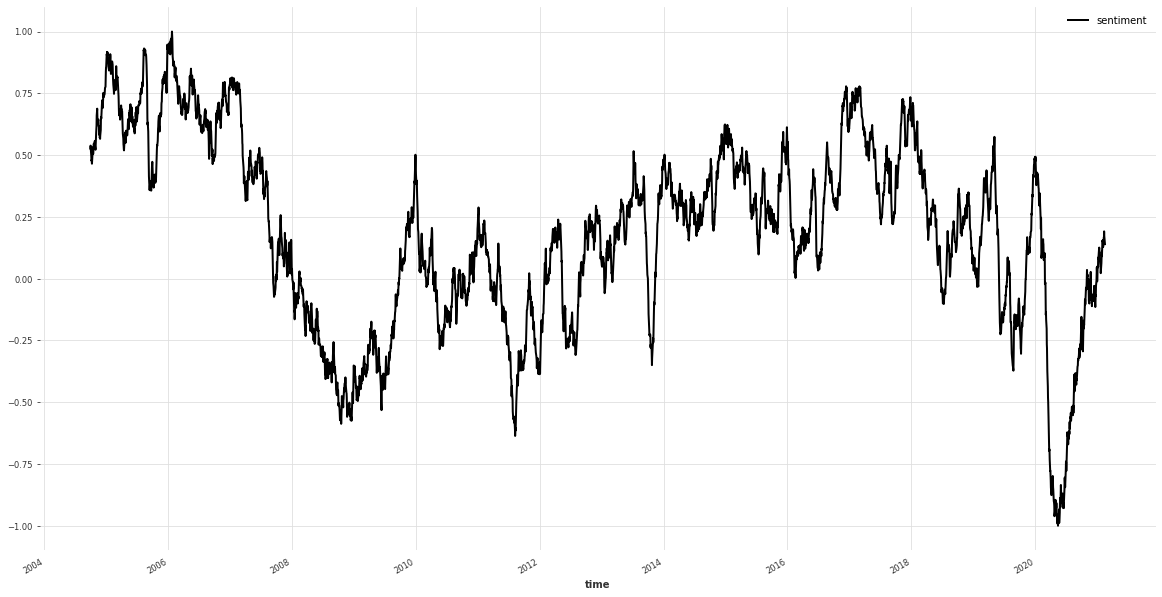

In [10]:
train_cov, val_cov =  series_cov_transformed.split_after(pd.Timestamp('20170901'))
series_cov_transformed.plot()

In [11]:
columns = ["Oil", "Inflation", "CPI", "Dollar Index", "GDP", "Unemployment", "Energy", "Gold",
"Materials", "Industrials", "Customer Discretionary", "Consumer Staples", "Health",
"Financials", "Technology", "Telecommunications", "Utilities", "Real Estate", "Spy"]

series = TimeSeries.from_dataframe(df, 'time', ['Oil', "CPI", "Dollar Index", "Spy"])

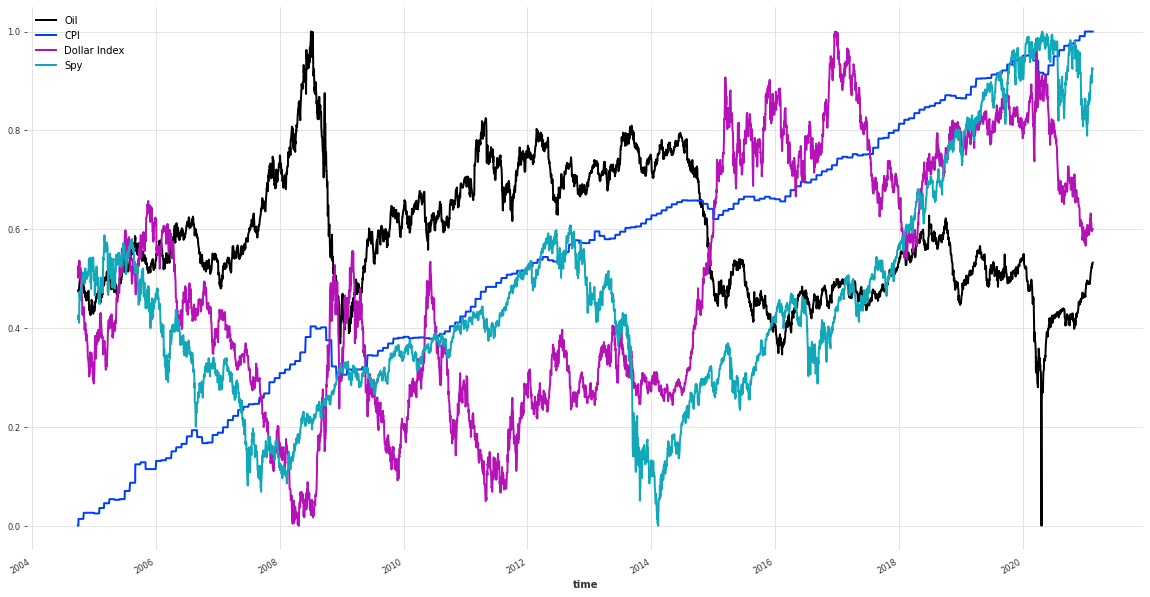

In [12]:
scaler = Scaler()
series_transformed = scaler.fit_transform(
    series
)  #scale the whole time series not caring about train/val split..

train, val =  series_transformed.split_after(pd.Timestamp('20170901'))
series_transformed.plot()

In [13]:
seasonality = check_seasonality(series_transformed["Spy"], max_lag=series_transformed.n_timesteps)
print(seasonality)

(True, 1943)


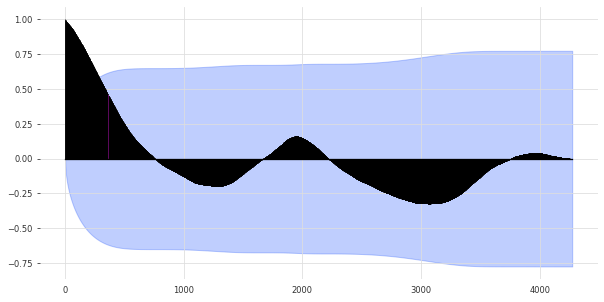

In [14]:
plot_acf(series_transformed["Spy"], 365, max_lag=series_transformed.n_timesteps-1)

In [15]:
stationary = stationarity_tests(series_transformed["Spy"])
print(stationary)

False


/usr/local/Cellar/python@3.9/3.9.0_1/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:2011: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


In [16]:
def tcn_model(kernal, dilation, train_series, val_series, past_covariates_train=None, past_covariates_val=None, future_covariates_train=None, future_covariates_val=None):
    model = TCNModel(
        input_chunk_length=365,
        output_chunk_length=7,
        n_epochs=50,
        optimizer_kwargs={"lr": 1e-3},
        dropout=0.2,
        dilation_base=dilation,
        random_state=0,
        kernel_size=kernal,
        num_filters=8,
        nr_epochs_val_period=1,
        likelihood=GaussianLikelihood(),
    )

    model.fit(
        series=train_series,
        val_series=val_series,
        past_covariates=past_covariates_train,
        val_past_covariates=past_covariates_val,
        future_covariates=future_covariates_train,
        val_future_covariates=future_covariates_val,
        verbose=True,
    )

    return model

In [17]:
def eval_model(model, series, past_covariates=None, future_covariates=None):
    backtest = model.historical_forecasts(
        series=series,
        past_covariates=past_covariates,
        future_covariates=future_covariates,
        start=0.7,
        forecast_horizon=7,
        stride=10,
        retrain=False,
        verbose=True,
    )
    #series[2000:].plot(label="actual")
    series.plot(label="actual")
    backtest.plot(label="backtest (H=7 day)")
    r2_score_value = r2_score(series, backtest)
    plt.title('R2:' + str(r2_score_value))
    plt.legend()
    print('Backtest RMSE = {}'.format(rmse(series, backtest)))

In [18]:
model = tcn_model(5, 2, train, val)

[2022-02-14 09:51:10,909] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 09:51:10,909] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 09:51:10,911] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-02-14 09:51:10,911] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-02-14 09:51:10,914] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-14 09:51:10,914] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Backtest RMSE = 0.024879157654184823


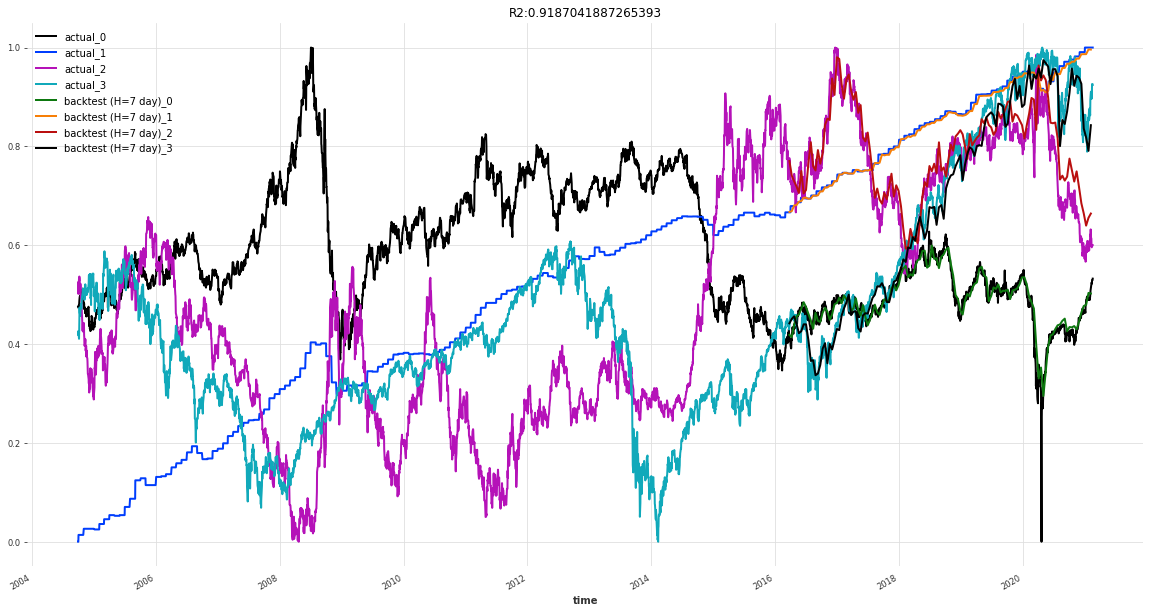

In [19]:
eval_model(model, series_transformed)

In [20]:
model = tcn_model(5, 2, train, val, train_cov, val_cov)

[2022-02-14 09:55:00,999] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 09:55:00,999] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 09:55:01,002] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-02-14 09:55:01,002] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 6
[2022-02-14 09:55:01,004] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-14 09:55:01,004] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Backtest RMSE = 0.024904793130938723


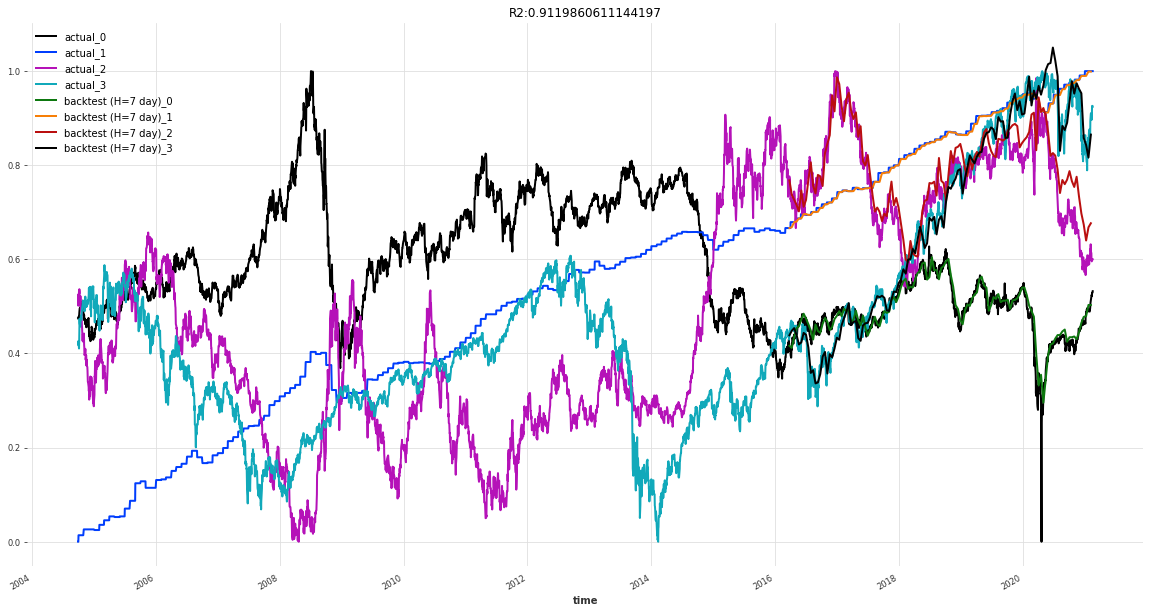

In [21]:
eval_model(model, series_transformed, series_cov_transformed)

In [22]:
model = tcn_model(3, 2, train, val)

[2022-02-14 09:59:01,671] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 09:59:01,671] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 09:59:01,673] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 7
[2022-02-14 09:59:01,673] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 7
[2022-02-14 09:59:01,676] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-14 09:59:01,676] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Backtest RMSE = 0.02417968711800389


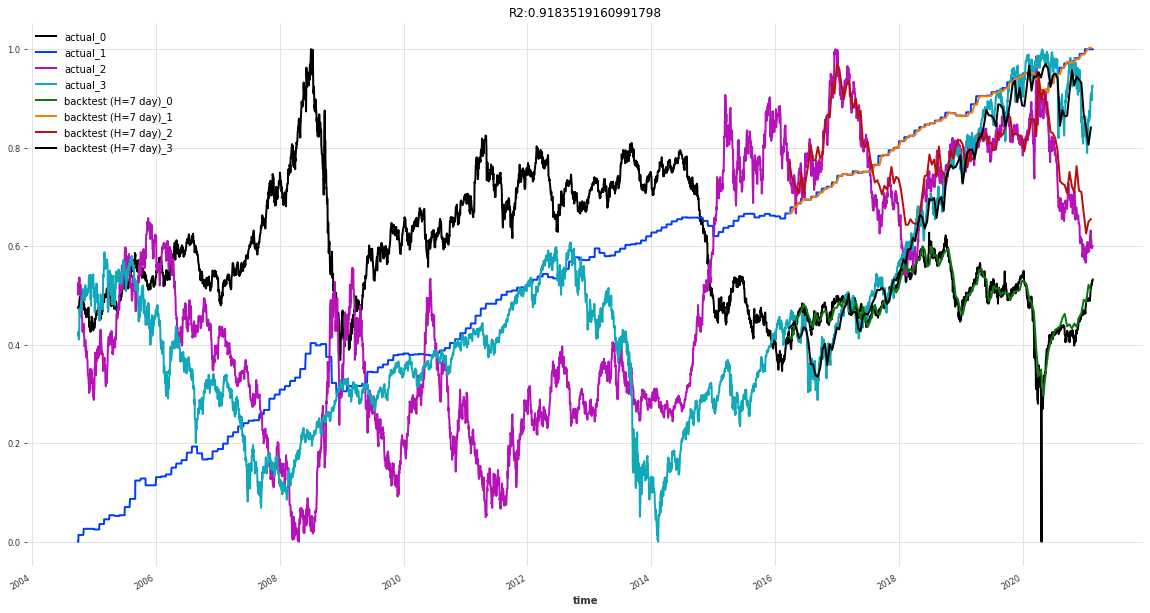

In [23]:
eval_model(model, series_transformed)

In [24]:
model = tcn_model(3, 2, train, val, train_cov, val_cov)

[2022-02-14 10:02:28,595] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 10:02:28,595] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 10:02:28,597] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 7
[2022-02-14 10:02:28,597] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 7
[2022-02-14 10:02:28,600] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-14 10:02:28,600] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Backtest RMSE = 0.02398544360509054


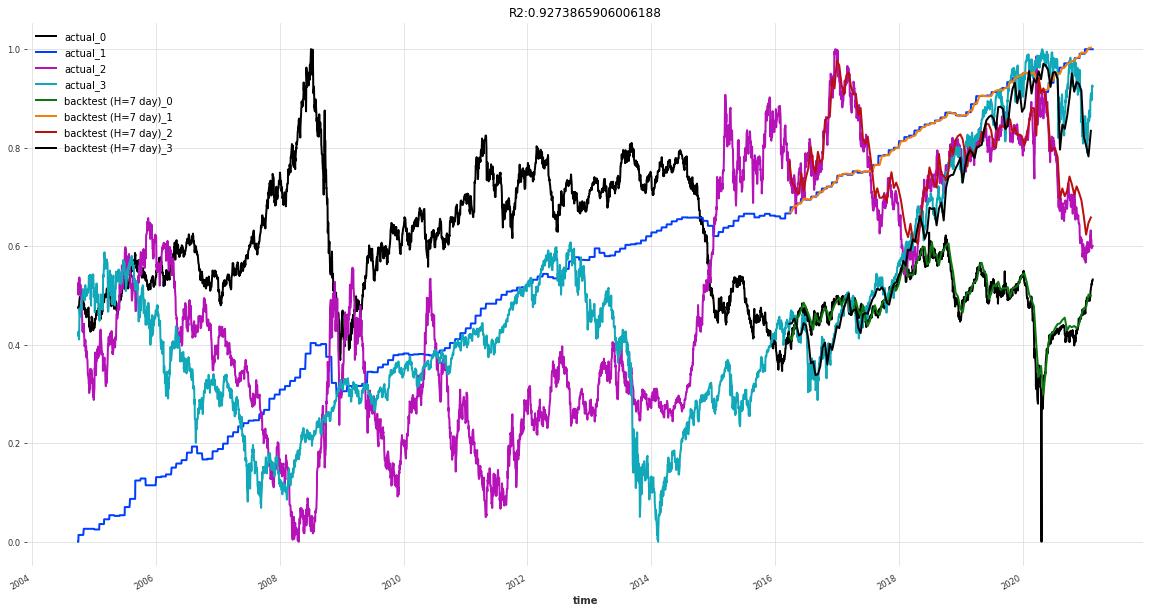

In [25]:
eval_model(model, series_transformed, series_cov_transformed)

In [26]:
model = tcn_model(7, 2, train, val)

[2022-02-14 10:06:03,675] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 10:06:03,675] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 10:06:03,677] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-02-14 10:06:03,677] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-02-14 10:06:03,679] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-14 10:06:03,679] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Backtest RMSE = 0.032965025027076794


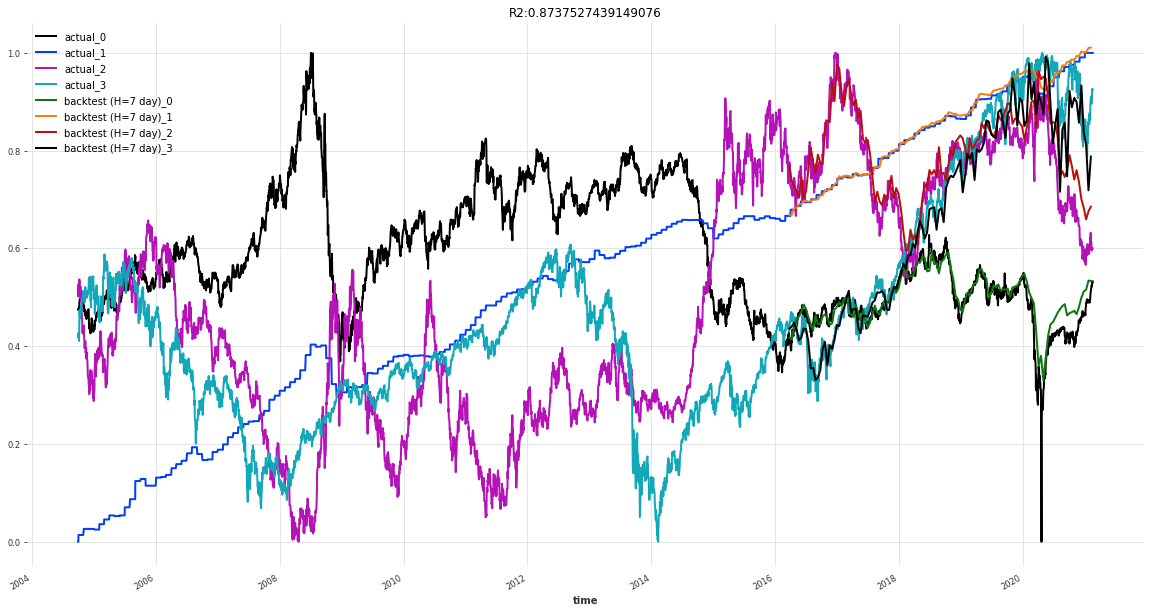

In [27]:
eval_model(model, series_transformed)

In [28]:
model = tcn_model(7, 2, train, val, train_cov, val_cov)

[2022-02-14 10:09:58,726] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 10:09:58,726] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 3002 samples.
[2022-02-14 10:09:58,729] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-02-14 10:09:58,729] INFO | darts.models.forecasting.tcn_model | Number of layers chosen: 5
[2022-02-14 10:09:58,732] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-02-14 10:09:58,732] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Backtest RMSE = 0.02250130469177549


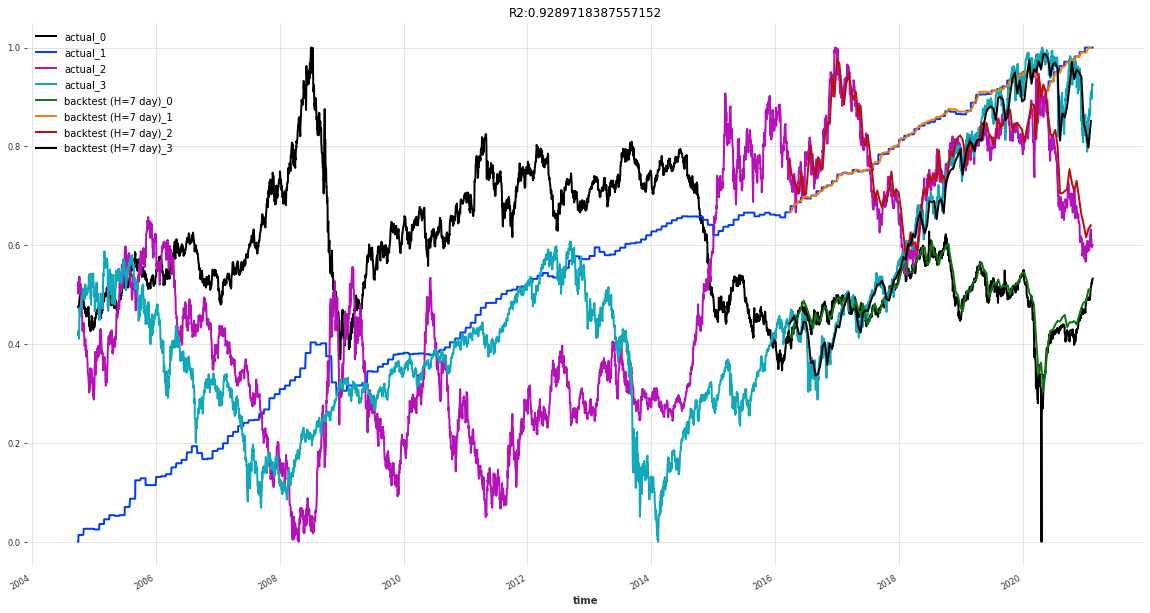

In [29]:
eval_model(model, series_transformed, series_cov_transformed)